# setup

In [1]:
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pprint import pprint
from pyspark.sql import types, Row, Column
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

In [2]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "finalProject"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

# EDA

get line count, check how big the file is

In [3]:
!wc -l data/train.txt
!wc -l data/test.txt

45840617 data/train.txt
6042135 data/test.txt


read in data in parquet format

In [3]:
train = spark.read.parquet('data/train.parquet')

examine the schema

In [4]:
train.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: string (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullable = tru

We would like to rename the columns so that we can distinguish between label, numerical data, and categorical data

In [5]:
def renameCols(df, trainingSet=True):
    
    # if this is the training set, change the name of the label
    # if test set there is no label
    if trainingSet:
        # rename label column
        df = df.withColumnRenamed('_c0', 'label')
        numericalCols = [c for c in df.columns[1:14]]
        categoricalCols = [c for c in df.columns[14:]]
    else:
        numericalCols = [c for c in df.columns[:13]]
        categoricalCols = [c for c in df.columns[13:]]

    # rename numerical columns
    for i,c in enumerate(numericalCols):
        newName = 'n' + str(i)
        df = df.withColumnRenamed(c, newName)

    for i,c in enumerate(categoricalCols):
        newName = 'c' + str(i)
        df = df.withColumnRenamed(c, newName)
        
    return df

In [6]:
train = renameCols(train)

In [7]:
train.columns

['label',
 'n0',
 'n1',
 'n2',
 'n3',
 'n4',
 'n5',
 'n6',
 'n7',
 'n8',
 'n9',
 'n10',
 'n11',
 'n12',
 'c0',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c6',
 'c7',
 'c8',
 'c9',
 'c10',
 'c11',
 'c12',
 'c13',
 'c14',
 'c15',
 'c16',
 'c17',
 'c18',
 'c19',
 'c20',
 'c21',
 'c22',
 'c23',
 'c24',
 'c25']

We would like to cast the numerical data and label as type `float` for easy mathematical manipulation later on

In [8]:
def castNumericalAsFloat(df):
    numericalCols = [c for c in df.columns if 'n' in c or 'label' in c]
    for c in numericalCols:
        df = df.withColumn(c, df[c].cast('float'))
        
    return df

In [9]:
train = castNumericalAsFloat(train)

In [10]:
train.printSchema()

root
 |-- label: float (nullable = true)
 |-- n0: float (nullable = true)
 |-- n1: float (nullable = true)
 |-- n2: float (nullable = true)
 |-- n3: float (nullable = true)
 |-- n4: float (nullable = true)
 |-- n5: float (nullable = true)
 |-- n6: float (nullable = true)
 |-- n7: float (nullable = true)
 |-- n8: float (nullable = true)
 |-- n9: float (nullable = true)
 |-- n10: float (nullable = true)
 |-- n11: float (nullable = true)
 |-- n12: float (nullable = true)
 |-- c0: string (nullable = true)
 |-- c1: string (nullable = true)
 |-- c2: string (nullable = true)
 |-- c3: string (nullable = true)
 |-- c4: string (nullable = true)
 |-- c5: string (nullable = true)
 |-- c6: string (nullable = true)
 |-- c7: string (nullable = true)
 |-- c8: string (nullable = true)
 |-- c9: string (nullable = true)
 |-- c10: string (nullable = true)
 |-- c11: string (nullable = true)
 |-- c12: string (nullable = true)
 |-- c13: string (nullable = true)
 |-- c14: string (nullable = true)
 |-- c15: st

## Examining numerical data

calculate basic statistics on the numerical data. This allows us to determine column counts and get a sense of the distribution (which we will explore further later

In [11]:
# full training set
start = time.time()
stats = train[train.columns[1:14]].describe()
means = np.array(stats[stats['summary'] == 'mean'].collect())[0][1:]
stdevs = np.array(stats[stats['summary'] == 'stddev'].collect())[0][1:]
print((time.time() - start) / 60)

1.9249119957288106


In [12]:
stats.show(vertical=True)

-RECORD 0---------------------
 summary | count              
 n0      | 25047061           
 n1      | 45840617           
 n2      | 36001170           
 n3      | 35903248           
 n4      | 44657500           
 n5      | 35588289           
 n6      | 43857751           
 n7      | 45817844           
 n8      | 43857751           
 n9      | 25047061           
 n10     | 43857751           
 n11     | 10768965           
 n12     | 35903248           
-RECORD 1---------------------
 summary | mean               
 n0      | 3.5024133170754044 
 n1      | 105.84841979766546 
 n2      | 26.913041020611274 
 n3      | 7.322680248873305  
 n4      | 18538.991664871523 
 n5      | 116.06185085211598 
 n6      | 16.333130032135028 
 n7      | 12.517042137556713 
 n8      | 106.1098234380509  
 n9      | 0.6175294977722137 
 n10     | 2.7328343170173044 
 n11     | 0.9910356287721244 
 n12     | 8.217461161174054  
-RECORD 2---------------------
 summary | stddev             
 n0     

In [13]:
N = train.count()

In [14]:
numericNans = {}
for c in stats.columns[1:]:
    numericNans[c] = N - int(stats.select(c).collect()[0][0])
print('missing numeric values\n')
pprint(numericNans)

missing numeric values

{'n0': 20793556,
 'n1': 0,
 'n10': 1982866,
 'n11': 35071652,
 'n12': 9937369,
 'n2': 9839447,
 'n3': 9937369,
 'n4': 1183117,
 'n5': 10252328,
 'n6': 1982866,
 'n7': 22773,
 'n8': 1982866,
 'n9': 20793556}


We have a wide range of values in the numerical data. Column `n4` ranges from 0 to 2e7 whereas column `n9` has a maximum value of 11.  this indicates that the numerical data will need normalization in order to properly train. We can also see we have a large amount of missing values. Column `n1` is actually not missing any values, but column `n0` and `n9` are missing nearly half the data and column `n11` is missing over 75% of the total rows. Before we move on to examining the categorical data, we first want to dig into the numerical data a bit further. We will take a small sample to examine the data further.

In [15]:
s = train.sample(False, 0.001)
s.count()

45699

In [16]:
df = s.toPandas()

In [17]:
df.iloc[:,1:14].head()

,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12
0,NaN,62.0,1.0,8.0,13750.0,NaN,NaN,8.0,NaN,NaN,NaN,0.0,8.0
1,2.0,1.0,1.0,4.0,14.0,4.0,2.0,5.0,4.0,1.0,1.0,NaN,4.0
2,NaN,1.0,19.0,34.0,502.0,227.0,153.0,35.0,480.0,NaN,11.0,NaN,34.0
3,2.0,180.0,5.0,5.0,349.0,6.0,3.0,6.0,9.0,1.0,2.0,NaN,6.0
4,NaN,28.0,9.0,25.0,13433.0,711.0,2.0,29.0,300.0,NaN,1.0,0.0,29.0


We first want to examine if any of our variables already appear to be strong indicators of clicks. We can look at the total number of counts per clicks for each numerical variable

Text(0.5,1,'Total Counts per Label')

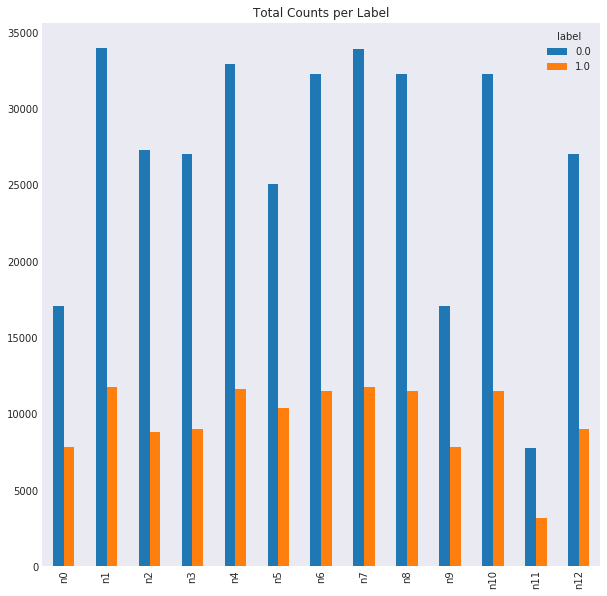

In [18]:
countByLabel = df.groupby(df.columns[0]).count()
countByLabel.iloc[:,:13].transpose().plot(kind='bar', figsize=(10,10))
plt.title('Total Counts per Label')

So there doesn't seem to be much of a trend with any particular column. Most columns show roughly 2/3 - 3/4 of non-clicks for our sample. Let's see if any of these variables show correlation with one another

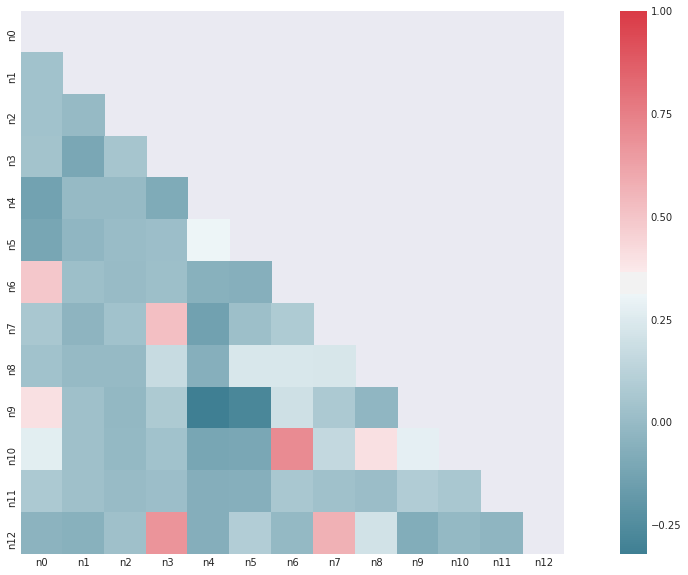

In [19]:
corr = df.iloc[:,1:14].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, square=True)

It is interesting to see that we have little to no correlation in our numeric variables. We see that `n6` and `n10` might be the most strongly positively correlated, but they only have a correlation coefficient of ~0.6. If we were going to be using this data for inference (as we might if we were designing the ad that we were trying to get clicks on) then we may consider keeping only one of these variables so as to avoid multicollinearity in our model. Since we only care about predictive power, we will leave these variables in our model. 

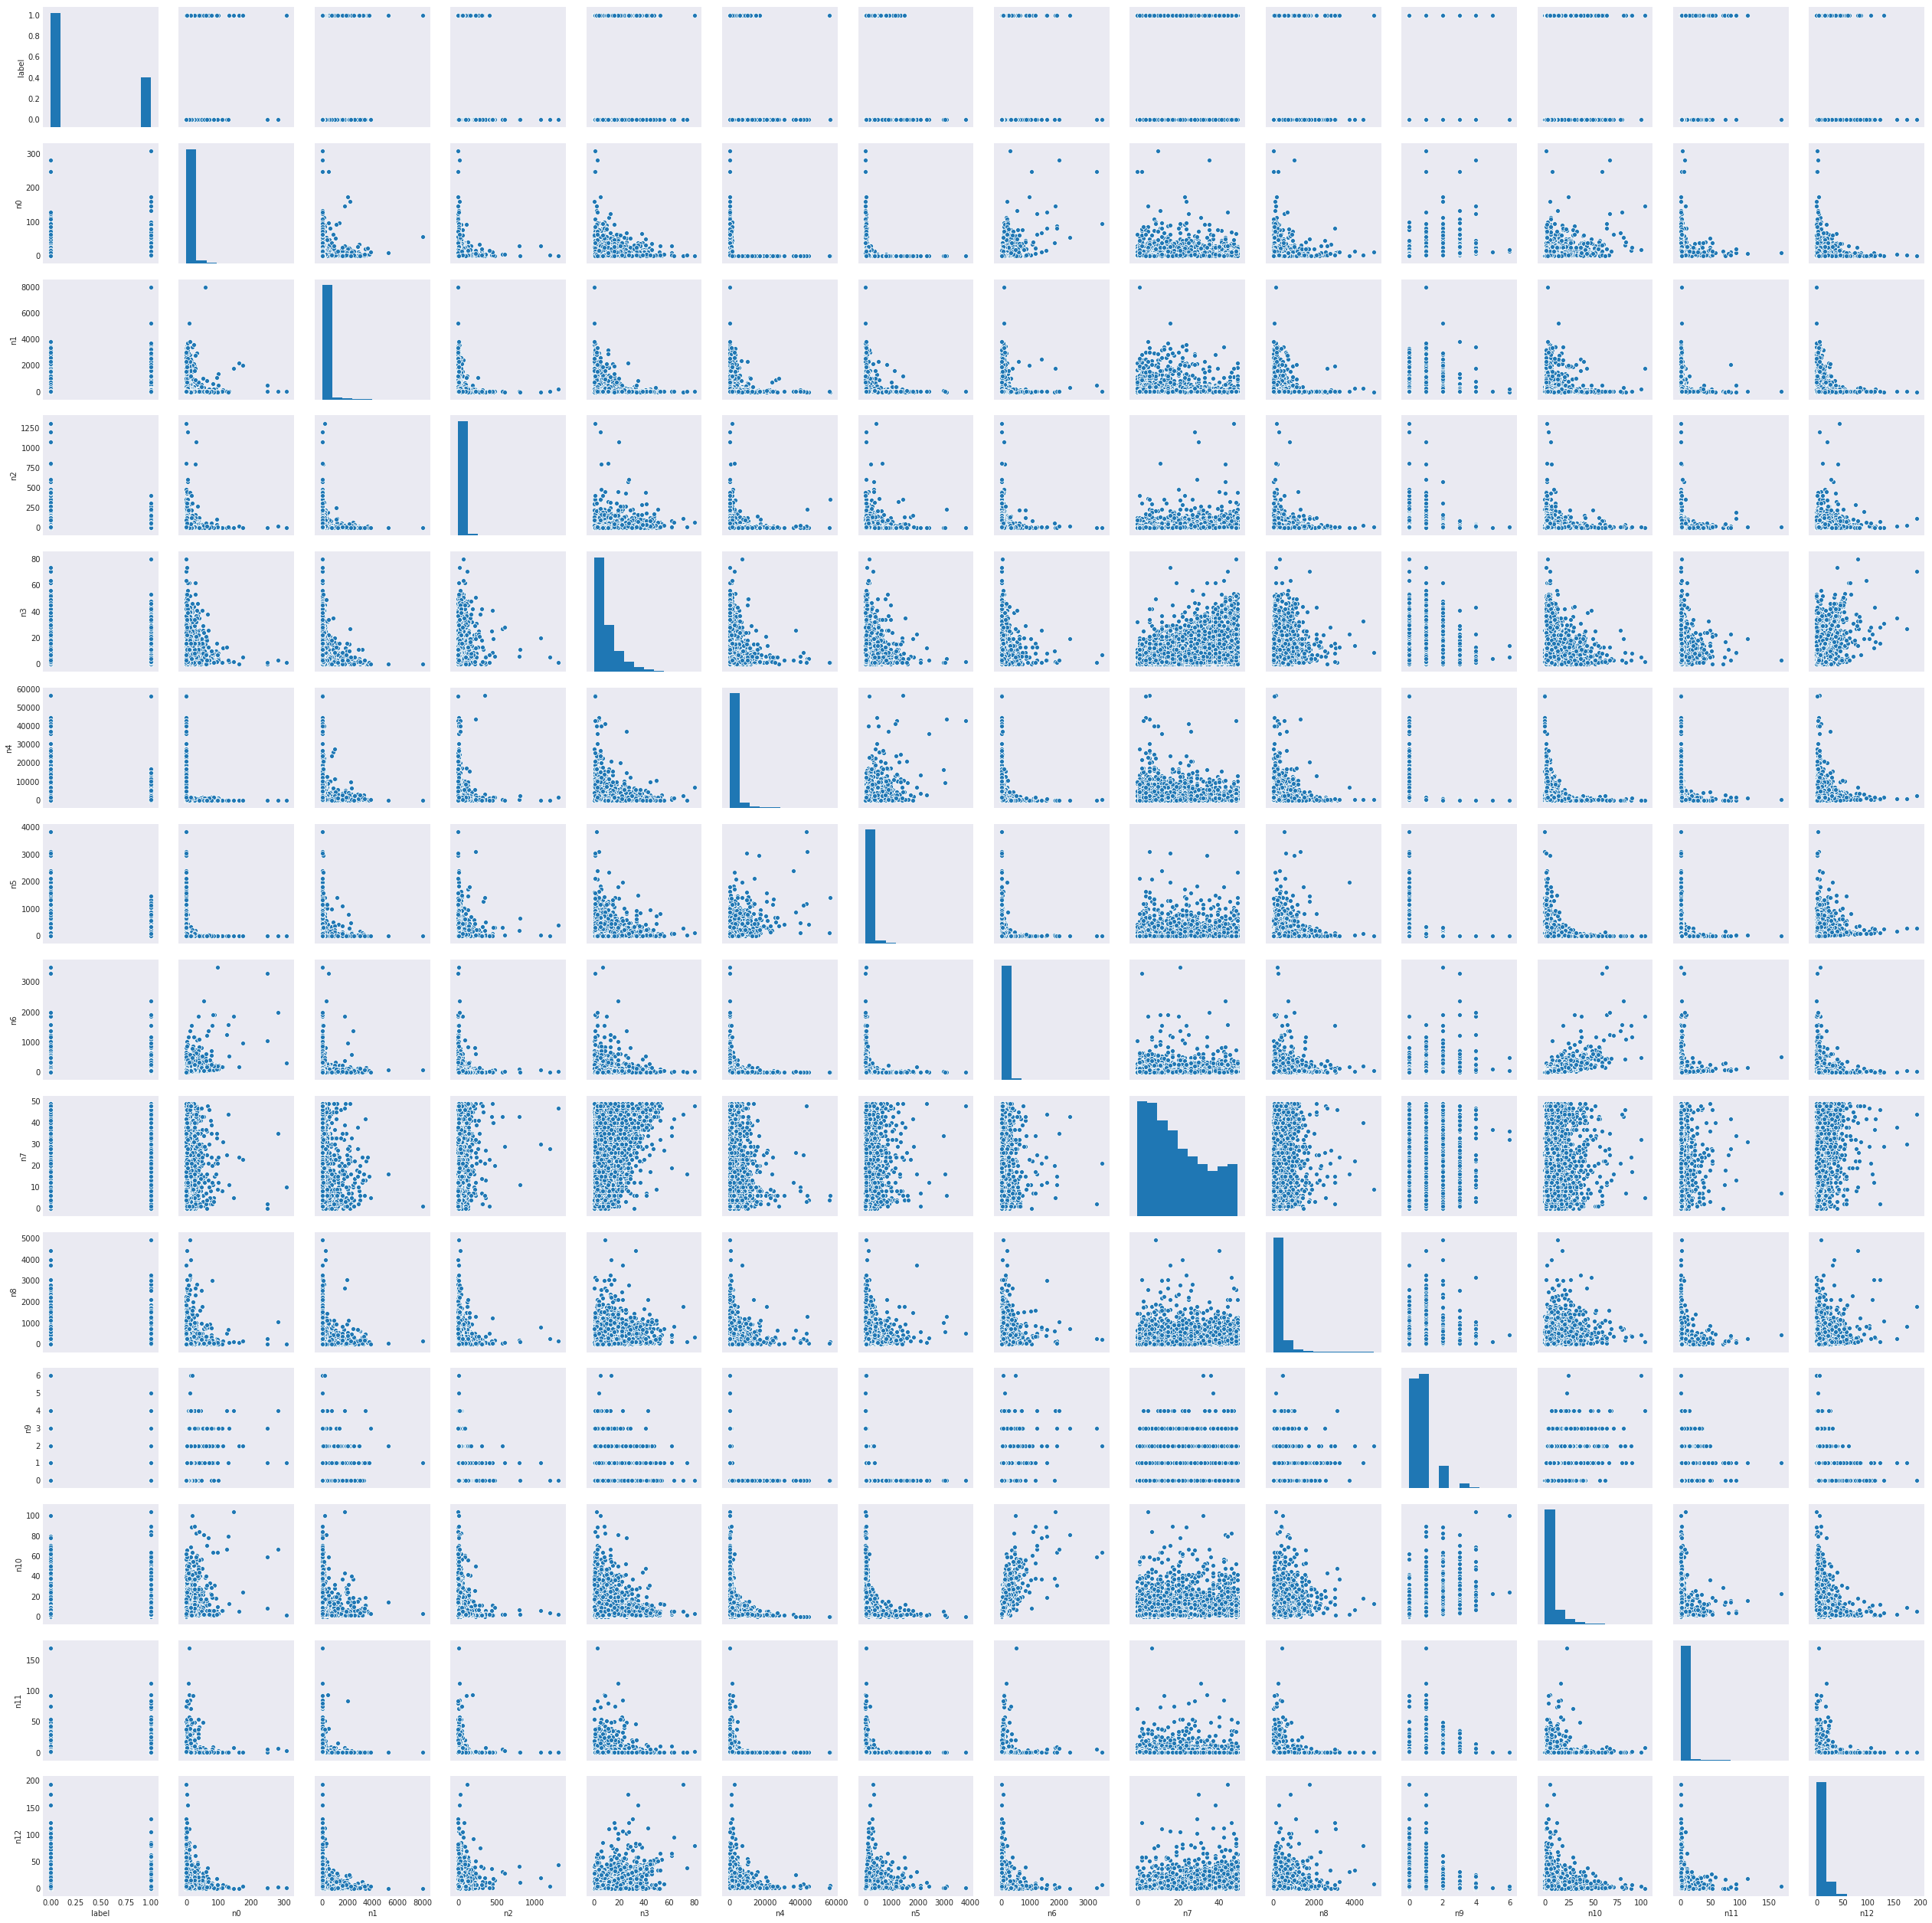

In [20]:
sns.pairplot(df.iloc[:,:14].dropna())

In [21]:
def plotHistograms(df):
    dim = np.ceil(np.sqrt(len(df.columns[1:14])))
    fig = plt.figure(figsize=(4,4))
    fig.subplots_adjust(left=0, right=2, bottom=0, top=2)
    for i,c in enumerate(df.columns[1:14]):
        ax = fig.add_subplot(dim, dim, i + 1)
        ax.hist(df[c].dropna(), bins=50)
        ax.set_title(df.columns[i + 1])

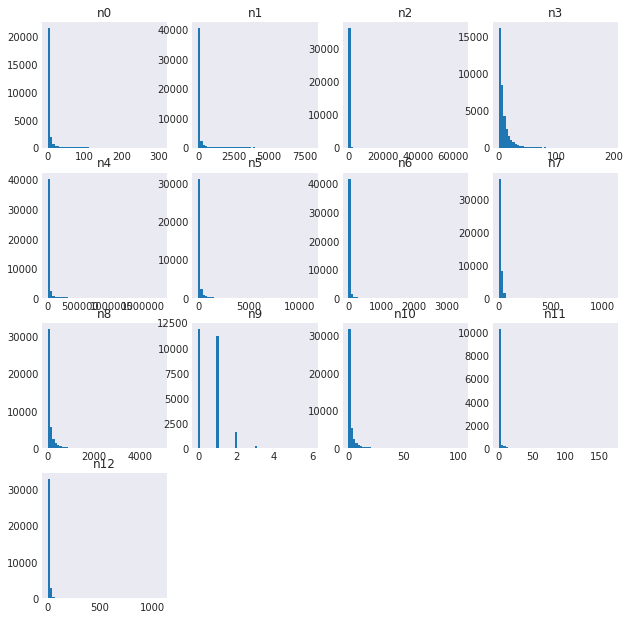

In [22]:
plotHistograms(df)

We see from the histogram that we have pretty extreme skew in all our numeric variables. This reinforces our assumption from the basic statistics that we will need to perform some form of normalization on the numeric columns. Rather than a standard normalization, we want to see if log transformation will help to create more normal distributions in our data

In [23]:
def plotHistogramsWithLogTransformation(df):
    dim = np.ceil(np.sqrt(len(df.columns[1:14])))
    fig = plt.figure(figsize=(4,4))
    fig.subplots_adjust(left=0, right=2, bottom=0, top=2)
    for i, col in enumerate(df.columns[1:14]):
        ax = fig.add_subplot(dim, dim, i + 1)
        c = df[col].copy()
        c.fillna(0, inplace=True)
        c[c != 0] = c[c != 0].apply(np.log)
        ax.hist(c.dropna(), bins=50)
        ax.set_title(df.columns[i + 1])

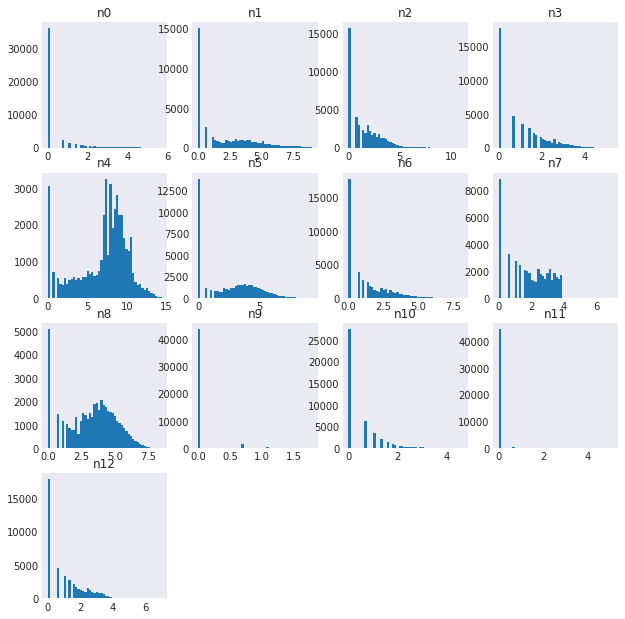

In [24]:
plotHistogramsWithLogTransformation(df)

The log transformation resolves the 

We can now start to examine the categorical data. In order to understand the size of our feature space, we need to understand the number of unique features (classes) in each categorical variable. Let's first look at the total counts, the number of missing values, and the number of the unique classes from each category

In [37]:
categoricalCounts = train[train.columns[14:]].summary('count')

In [38]:
categoricalCounts.show(vertical=True)

-RECORD 0-----------
 summary | count    
 c0      | 45840617 
 c1      | 45840617 
 c2      | 44281144 
 c3      | 44281144 
 c4      | 45840617 
 c5      | 40299992 
 c6      | 45840617 
 c7      | 45840617 
 c8      | 45840617 
 c9      | 45840617 
 c10     | 45840617 
 c11     | 44281144 
 c12     | 45840617 
 c13     | 45840617 
 c14     | 45840617 
 c15     | 44281144 
 c16     | 45840617 
 c17     | 45840617 
 c18     | 25667759 
 c19     | 25667759 
 c20     | 44281144 
 c21     | 10885544 
 c22     | 45840617 
 c23     | 44281144 
 c24     | 25667759 
 c25     | 25667759 



In [47]:
categoricalNulls = {}
for c in categoricalCounts.columns[1:]:
    categoricalNulls[c] = N - int(categoricalCounts.select(c).collect()[0][0])
print('missing categorical values\n')
pprint(categoricalNulls)

missing categorical values

{'c0': 0,
 'c1': 0,
 'c10': 0,
 'c11': 1559473,
 'c12': 0,
 'c13': 0,
 'c14': 0,
 'c15': 1559473,
 'c16': 0,
 'c17': 0,
 'c18': 20172858,
 'c19': 20172858,
 'c2': 1559473,
 'c20': 1559473,
 'c21': 34955073,
 'c22': 0,
 'c23': 1559473,
 'c24': 20172858,
 'c25': 20172858,
 'c3': 1559473,
 'c4': 0,
 'c5': 5540625,
 'c6': 0,
 'c7': 0,
 'c8': 0,
 'c9': 0}


So many of our categorical columns are not missing any data, but some are missing huge amounts of data. This could be a problem for our feature space. We will need to decide if `null` should be considered a unique class or not for each category. Now we can 

In [48]:
uniqueCounts = {}
for c in train.columns[14:]:
    count = train.agg(F.countDistinct(c).alias('c')).collect()[0]['c']
    uniqueCounts[c] = count

In [49]:
uniqueCounts

{'c0': 1460,
 'c1': 583,
 'c2': 10131226,
 'c3': 2202607,
 'c4': 305,
 'c5': 23,
 'c6': 12517,
 'c7': 633,
 'c8': 3,
 'c9': 93145,
 'c10': 5683,
 'c11': 8351592,
 'c12': 3194,
 'c13': 27,
 'c14': 14992,
 'c15': 5461305,
 'c16': 10,
 'c17': 5652,
 'c18': 2172,
 'c19': 3,
 'c20': 7046546,
 'c21': 17,
 'c22': 15,
 'c23': 286180,
 'c24': 104,
 'c25': 142571}

In [54]:
print('Total Size of Feature Space: ', np.sum(list(uniqueCounts.values())))

Total Size of Feature Space:  33762565


Obviously it would be crazy to try to build any model with a feature space of 33762565. This is nearly the same size as the dataset itself. Clearly we will need to perform some dimensionality reduction. 

Let's revisit the count-per-label plot for our sample set, this time looking at the categorical columns

Text(0.5,1,'Total Counts per Label')

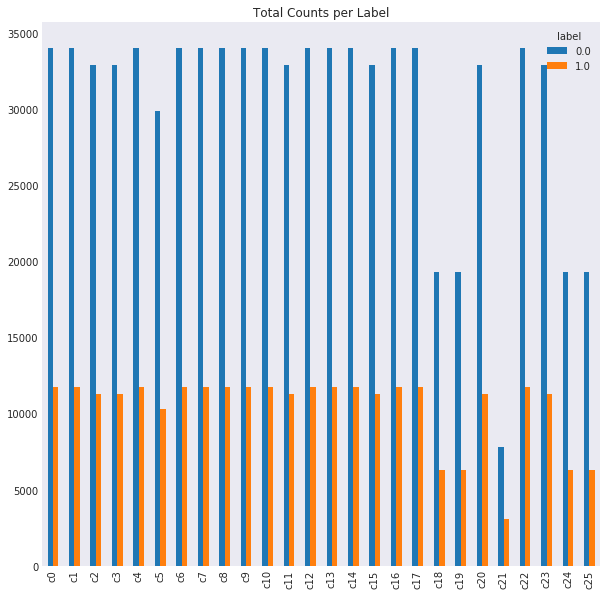

In [55]:
countByLabel.iloc[:,13:].transpose().plot(kind='bar', figsize=(10,10))
plt.title('Total Counts per Label')

Again no obvious trends or correlations between any particular categories and our label column